[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//planetlabs/notebooks/blob/master/jupyter-notebooks/workflows/planet_sandbox_data/land-surface-temperature/urban-heat-monitoring.ipynb)


# Estimating Heat Waves and Urban Heat Island Intensity with Land Surface Temperature  

This Jupyter Notebook demonstrates how to analyze **heat waves** and quantify **Urban Heat Island (UHI) intensity** using Land Surface Temperature (LST) data from [Planetary Variables](https://docs.planet.com/data/planetary-variables/). By leveraging the [Statistics API](https://docs.sentinel-hub.com/api/latest/api/statistical/), [SentinelHubRequest](https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.api.process.html#module-sentinelhub.api.process) and [Land Surface Temperature](https://docs.planet.com/data/planetary-variables/land-surface-temperature/), we will:  
- Identify periods of heat waves based on temperature anomalies, and  
- Visualize and quantify UHI effects by mapping temperature differences between urban and rural areas.  

### Why is this important?  
Urban Heat Islands (UHIs) represent a critical environmental challenge, where urban areas experience significantly higher temperatures compared to their surroundings. This phenomenon, driven by factors such as dense construction, reduced vegetation, and human activities, exacerbates heat waves, creating public health risks and straining energy resources. Understanding UHI dynamics and identifying heat wave periods are vital for informed urban planning and mitigation strategies.  

### From Data to Action  
Based on the concept of “Tip and Cue”, Planet’s long archive 1 km LST is used to detect heatwave events (tip), while the Planet 100 m enables further spatial analysis of heightened risk (Cue) during the heatwave events. This approach enables a focused, in-depth investigation of heatwave impacts at a finer scale, optimizing resources by reserving the more computationally intensive high-resolution analysis for areas already flagged as high-risk during the initial temporal screening.

The insights derived from this analysis provide actionable intelligence for urban planners, policymakers, and environmental scientists. By understanding the spatial and temporal patterns of heat waves and UHIs, stakeholders can:  
- Develop targeted interventions, such as increasing urban greenery and reflective surfaces.  
- Optimize city designs to mitigate heat stress on vulnerable populations.  
- Integrate LST data into broader climate resilience frameworks.  

### Overview  
This notebook follows a structured approach to explore and analyze Land Surface Temperature data:  
1. **Data Retrieval**: Access LST data using the Statistics API and SentinelHubRequest.  
2. **Heat Wave Detection**: Define thresholds to identify heat wave periods using Planet long Archive LST at 1km resolution (Tips).  
3. **Urban Heat Island Mapping**: Compare areas within the cities using cumulative sum of LST to estimate UHI intensity.  
4. **Visualization**: Generate visual outputs for easy interpretation of heat wave patterns and UHI effects.  

This workflow bridges the gap between remote sensing data and real-world decision-making, enabling data-driven approaches to combat urban heating challenges.  

This notebook makes use of [Planet Sandbox Data](https://docs.planet.com/data/planet-sandbox-data/). You need a Planet account in order to access this data. If you don't already have an account, you can [sign up for a 30-day trial](https://insights.planet.com/sign-up/).

In [ ]:
# Uncomment the following line and run this cell only if you are using colab to install additional required packages
#%pip install -q sentinelhub --quiet

In [1]:
import json
import pandas as pd
import numpy as np
import getpass
import folium

import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

import sentinelhub
from sentinelhub import (
    Geometry,
    CRS,
    SentinelHubRequest,
    MimeType,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubDownloadClient,
)


## Credentials

The Sentinel Hub Python SDK requires a `client_id` and a `client_secret`. To obtain your `client_id` & `client_secret`, you need to navigate to your [account manager](insights.planet.com/account/), and in the **User Settings**, create a new OAuth client. More detailed instructions can be found in our [authentication documentation](https://docs.planet.com/develop/authentication/).

Once you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [in the documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite the default profile every time you run a new Jupyter Notebook.

The following cell checks for an existing default configuration. If none is found, you will be prompted for your credentials, which you can then optionally save.

In [ ]:
from sentinelhub import SHConfig

# Authenticate with the Sentinel Hub Python SDK; See docs: https://sentinelhub-py.readthedocs.io/en/latest/configure.html and https://docs.planet.com/develop/authentication
# If no default configuration detected, enter a client ID and secret to authenticate. These can be obtained by creating an OAuth client here: https://insights.planet.com/account
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    from getpass import getpass
    print('No credentials found, please provide the OAuth client ID and secret.')
    config.sh_client_id = getpass('Client ID: ')
    config.sh_client_secret = getpass('Client Secret: ')
    ## Uncomment the following lines to save your credentials to a configuration
    # config.save() 
    # print(f'Credentials saved to {SHConfig.get_config_location()}')
else:
    print(f'Using credentials stored here: {SHConfig.get_config_location()}')

### Define field of interest

In this example a city of interest has been selected in France: Bordeaux. The boundary is defined as a GeoJSON file in EPSG:4326. We will read the GeoJSON and plot the area of interest.

In [3]:
# Read a geojson containing a polygon representing the city of Bordeaux, France
bordeaux_json = json.loads('{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"id":1,"geometry":{"type":"Polygon","coordinates":[[[-0.5010451,44.8305334],[-0.5009287,44.8304508],[-0.5005348,44.8303401],[-0.4992243,44.8303225],[-0.4991796,44.830335],[-0.499147,44.8303922],[-0.4987829,44.8302245],[-0.4984255,44.8303943],[-0.4973212,44.8307332],[-0.4966279,44.8308141],[-0.4964404,44.830862],[-0.4961436,44.8309104],[-0.4958327,44.8308954],[-0.4956057,44.8309334],[-0.4951841,44.830941],[-0.4936707,44.830747],[-0.4935698,44.8306947],[-0.4933183,44.8306299],[-0.4934676,44.8302339],[-0.4930996,44.8302096],[-0.4930085,44.8301883],[-0.492673,44.8300564],[-0.4921232,44.8299528],[-0.4920223,44.8301198],[-0.4919369,44.8301479],[-0.4916494,44.8300937],[-0.4914992,44.830025],[-0.4914685,44.8300298],[-0.4913354,44.8301252],[-0.4908946,44.8298616],[-0.4900094,44.8295021],[-0.489562,44.8293505],[-0.4896098,44.8292786],[-0.4894601,44.8291834],[-0.4890789,44.8290586],[-0.488913,44.8290198],[-0.4888672,44.8289859],[-0.488786,44.8289985],[-0.4884462,44.8289197],[-0.4883341,44.8288798],[-0.4881588,44.8287693],[-0.4880879,44.8287048],[-0.4878968,44.8286009],[-0.4877352,44.828412],[-0.487603,44.8283709],[-0.4875319,44.8283239],[-0.4868612,44.8281684],[-0.48665,44.8279835],[-0.4861442,44.8279906],[-0.4860044,44.8269413],[-0.4857988,44.8269548],[-0.4851644,44.826844],[-0.4842652,44.8268537],[-0.4832428,44.8269037],[-0.481997,44.8267632],[-0.4790094,44.8265565],[-0.477551,44.8264842],[-0.4758466,44.8263758],[-0.4753684,44.8260191],[-0.474864,44.8255049],[-0.4744811,44.8252547],[-0.4739419,44.824848],[-0.4726033,44.8238837],[-0.4726662,44.8238385],[-0.4729574,44.8235326],[-0.4731114,44.8233503],[-0.4732121,44.823174],[-0.4734504,44.8229317],[-0.4735603,44.8228959],[-0.4737631,44.8229588],[-0.4739132,44.8229321],[-0.4740742,44.8228967],[-0.4745421,44.8226933],[-0.4750251,44.8225873],[-0.4756078,44.8223051],[-0.4758403,44.8222565],[-0.4762306,44.8220567],[-0.4770083,44.8218674],[-0.4773061,44.8217775],[-0.4778477,44.8216551],[-0.4781485,44.8215302],[-0.4787303,44.821205],[-0.4789048,44.8210635],[-0.4791251,44.8206909],[-0.4794465,44.8203158],[-0.4796994,44.82026],[-0.4799183,44.8198294],[-0.4802843,44.8195616],[-0.4811852,44.8187275],[-0.4812912,44.8185848],[-0.4811508,44.818475],[-0.4811467,44.8183885],[-0.4812551,44.818192],[-0.4813688,44.8180481],[-0.4814431,44.8179608],[-0.4816186,44.8178053],[-0.4817056,44.8176893],[-0.4819012,44.8176539],[-0.4821295,44.8175711],[-0.4823043,44.8174871],[-0.48255,44.8174526],[-0.4829176,44.8173464],[-0.4831504,44.8173375],[-0.4832587,44.8172934],[-0.4839854,44.8171514],[-0.484122,44.8171442],[-0.4845308,44.8170433],[-0.4849637,44.8168668],[-0.4850787,44.8168034],[-0.4853385,44.8167457],[-0.4854165,44.816685],[-0.4854372,44.8166431],[-0.4855403,44.8165931],[-0.4859142,44.8163038],[-0.4860389,44.8162341],[-0.48609,44.8161536],[-0.4861537,44.8160962],[-0.4863074,44.8160219],[-0.4863332,44.8160135],[-0.4865008,44.8160454],[-0.4865855,44.8160431],[-0.4866707,44.8159923],[-0.4871362,44.8158955],[-0.487438,44.8157654],[-0.4877024,44.815777],[-0.4885541,44.8155497],[-0.4888718,44.8153808],[-0.4889427,44.815226],[-0.4893093,44.8152114],[-0.48948,44.8151862],[-0.4894895,44.8151386],[-0.4896992,44.8149669],[-0.4897404,44.8148515],[-0.489826,44.8148267],[-0.4899568,44.81474],[-0.4901953,44.8147988],[-0.4902911,44.8147928],[-0.4902953,44.814738],[-0.4903613,44.8146734],[-0.4905206,44.8146737],[-0.4905762,44.8145598],[-0.4907162,44.814509],[-0.4908602,44.8143968],[-0.4910193,44.8143171],[-0.4912593,44.8141503],[-0.4917457,44.8140516],[-0.4919186,44.8140498],[-0.4921425,44.8139403],[-0.492317,44.813772],[-0.4923857,44.8137325],[-0.4935296,44.8132597],[-0.493685,44.8131536],[-0.4936114,44.8130914],[-0.4936058,44.8130267],[-0.4935553,44.8129179],[-0.493544,44.8128203],[-0.4934617,44.8126798],[-0.4934972,44.8125774],[-0.4935503,44.8125315],[-0.4936428,44.8123707],[-0.4937584,44.8123142],[-0.4939101,44.8121365],[-0.4949016,44.8117229],[-0.4949035,44.8116655],[-0.494858,44.8116221],[-0.494812,44.8115211],[-0.4946845,44.8113874],[-0.494553,44.8111817],[-0.4942968,44.8108597],[-0.4942425,44.8107096],[-0.4942593,44.810678],[-0.4942493,44.8106353],[-0.4942813,44.810562],[-0.4942727,44.810419],[-0.4943125,44.8103442],[-0.4943092,44.8102619],[-0.4943536,44.8101207],[-0.4943843,44.810047],[-0.4944846,44.8098941],[-0.4945262,44.8098617],[-0.4945384,44.8098177],[-0.4945801,44.8097794],[-0.4946095,44.809719],[-0.4946116,44.8096516],[-0.4946652,44.8095942],[-0.4946885,44.8094918],[-0.494675,44.8093606],[-0.4947151,44.8091891],[-0.4947185,44.8089221],[-0.494814,44.8087033],[-0.4948554,44.8084614],[-0.4948559,44.808292],[-0.4949034,44.808065],[-0.4950146,44.8078309],[-0.4953108,44.80754],[-0.4954894,44.8073392],[-0.4958386,44.8070564],[-0.4961336,44.8068865],[-0.4965716,44.806678],[-0.4966974,44.8065573],[-0.4970064,44.8061756],[-0.4971234,44.8060866],[-0.4972943,44.8059775],[-0.4979809,44.8056449],[-0.4981019,44.8056019],[-0.4982277,44.8055625],[-0.4982495,44.8055718],[-0.4982593,44.8056317],[-0.4983202,44.8056663],[-0.4983964,44.8056612],[-0.4993486,44.8053477],[-0.4996865,44.8052742],[-0.5002657,44.8050602],[-0.5003995,44.8049815],[-0.5006914,44.8048731],[-0.5008792,44.804854],[-0.5011776,44.8047353],[-0.5014218,44.8046924],[-0.5016744,44.8045906],[-0.5020166,44.8044923],[-0.5020999,44.8046345],[-0.5034224,44.804451],[-0.5044903,44.8043262],[-0.5051289,44.8042709],[-0.5067304,44.8040662],[-0.5069733,44.8040076],[-0.5071551,44.8039437],[-0.5081252,44.8034766],[-0.5083416,44.8033903],[-0.5085152,44.8033568],[-0.5086387,44.8033424],[-0.5089184,44.8033542],[-0.5123181,44.8036198],[-0.5125474,44.8036505],[-0.5151108,44.803587],[-0.5167075,44.803528],[-0.5171075,44.8034561],[-0.5171861,44.8034561],[-0.5172296,44.8034765],[-0.5175686,44.8034004],[-0.5186471,44.8030679],[-0.5204685,44.8024109],[-0.5218748,44.8040922],[-0.5224191,44.8046453],[-0.5237973,44.8062688],[-0.527409,44.8053831],[-0.5267002,44.8025178],[-0.5261114,44.8009764],[-0.525719,44.7997515],[-0.5254333,44.798798],[-0.5251388,44.7973248],[-0.5246612,44.794692],[-0.524493,44.7942532],[-0.5243611,44.7939846],[-0.5241159,44.7935719],[-0.5234862,44.7925897],[-0.5230686,44.7920652],[-0.5235202,44.7918352],[-0.523898,44.7916745],[-0.5248176,44.791343],[-0.5255905,44.7910898],[-0.5266364,44.7908441],[-0.5277015,44.7907218],[-0.5280098,44.7907469],[-0.5282066,44.7908074],[-0.5285532,44.7908101],[-0.5290876,44.7909476],[-0.5295094,44.7910052],[-0.5297909,44.7910743],[-0.5299373,44.7910523],[-0.5301714,44.791067],[-0.5304303,44.7911593],[-0.5306048,44.7911955],[-0.5311593,44.7912334],[-0.5311206,44.7903163],[-0.5326543,44.7901848],[-0.5328176,44.7899089],[-0.5332674,44.7895672],[-0.5332782,44.7892485],[-0.535301,44.7896172],[-0.5354785,44.789638],[-0.535608,44.7891949],[-0.5356792,44.7890187],[-0.5357957,44.788808],[-0.5359508,44.7884306],[-0.5364308,44.7866173],[-0.5383248,44.7870888],[-0.5396464,44.7875026],[-0.5402914,44.7876888],[-0.5434159,44.7885154],[-0.5465702,44.7893908],[-0.5468979,44.7893111],[-0.5476783,44.7890708],[-0.547669,44.7890555],[-0.5488281,44.7887124],[-0.5496143,44.7885257],[-0.55011,44.788391],[-0.5517907,44.7877152],[-0.5515411,44.787363],[-0.5527828,44.7867232],[-0.5528254,44.7866912],[-0.5528625,44.7866208],[-0.5529061,44.7865841],[-0.5529526,44.7865921],[-0.5535521,44.7868605],[-0.5537385,44.7869605],[-0.5537897,44.7866119],[-0.5539002,44.7863836],[-0.5541754,44.7860718],[-0.5542225,44.7859294],[-0.5544495,44.7858828],[-0.5549925,44.7857],[-0.555516,44.7855643],[-0.5558189,44.7858488],[-0.5563885,44.7856401],[-0.5573236,44.7856131],[-0.5573936,44.785556],[-0.5583845,44.7853487],[-0.55785,44.7838991],[-0.5593743,44.7834773],[-0.5602432,44.7833208],[-0.5607004,44.7832981],[-0.5612169,44.7832351],[-0.5614683,44.7832793],[-0.5635968,44.7834111],[-0.5649874,44.7834522],[-0.565723,44.783509],[-0.5661713,44.7835158],[-0.5663232,44.7852259],[-0.5665924,44.787775],[-0.5668969,44.7910613],[-0.566999,44.7915745],[-0.5681029,44.7962475],[-0.568243,44.7966388],[-0.5695354,44.7990583],[-0.570829,44.801534],[-0.5713744,44.8028259],[-0.5719144,44.8040374],[-0.5726244,44.8057022],[-0.5728968,44.8052451],[-0.5735709,44.8045079],[-0.5737502,44.8042441],[-0.5738786,44.8040352],[-0.5739649,44.8038549],[-0.5740814,44.8033503],[-0.5741407,44.8032089],[-0.5742324,44.8030715],[-0.5748718,44.802274],[-0.5753374,44.8016233],[-0.5755027,44.8012977],[-0.5757892,44.8008738],[-0.5760279,44.8005681],[-0.57615,44.8004466],[-0.5765127,44.8002149],[-0.5766229,44.7999925],[-0.5768083,44.7994802],[-0.5769507,44.7992213],[-0.5771406,44.7989743],[-0.5777012,44.7983717],[-0.578164,44.7979102],[-0.5784378,44.7976708],[-0.5792188,44.7968577],[-0.5805442,44.7953148],[-0.5806837,44.7951105],[-0.581407,44.7952688],[-0.5814229,44.7946182],[-0.5814311,44.7945444],[-0.5815016,44.7944023],[-0.5816867,44.7942047],[-0.5825954,44.7933349],[-0.5839778,44.7920374],[-0.5842434,44.7917562],[-0.5846815,44.7909118],[-0.5847465,44.7908079],[-0.5848725,44.7906603],[-0.5852733,44.7903058],[-0.5864022,44.7897098],[-0.5865676,44.7895779],[-0.5867032,44.7894365],[-0.5867688,44.7893388],[-0.5867891,44.7892735],[-0.5868007,44.7888654],[-0.5868481,44.7885974],[-0.586918,44.7883762],[-0.586986,44.7882455],[-0.5870103,44.7879605],[-0.5870029,44.7877156],[-0.5906361,44.787098],[-0.5908143,44.7870695],[-0.5908171,44.7871252],[-0.591858,44.7869386],[-0.5934099,44.787071],[-0.5949401,44.7869024],[-0.5956586,44.7868498],[-0.5958383,44.7868637],[-0.5961071,44.7869078],[-0.5971533,44.78735],[-0.5976498,44.7875123],[-0.5980397,44.787695],[-0.5985948,44.7881229],[-0.5998671,44.7889646],[-0.6007131,44.7895465],[-0.6012085,44.7898625],[-0.6013892,44.7900254],[-0.6020942,44.7908443],[-0.6024126,44.7903443],[-0.6027739,44.7904034],[-0.603445,44.7904832],[-0.6053313,44.79054],[-0.605315,44.7922846],[-0.6052844,44.7929422],[-0.6051407,44.7939263],[-0.6049808,44.7943128],[-0.6048139,44.7945832],[-0.6044898,44.7950527],[-0.6043399,44.7952186],[-0.6041585,44.795372],[-0.6034797,44.7958913],[-0.6037084,44.7960256],[-0.6044755,44.7965303],[-0.6053805,44.7969964],[-0.6056976,44.7971864],[-0.6060861,44.7974693],[-0.6068171,44.7980844],[-0.6068787,44.7980372],[-0.6074362,44.7983954],[-0.6069594,44.7989185],[-0.6065171,44.7994362],[-0.6059034,44.8001053],[-0.6056572,44.8063948],[-0.6059647,44.8079763],[-0.6057292,44.8085306],[-0.6056733,44.8088616],[-0.6058664,44.8094056],[-0.6059253,44.8097642],[-0.6059764,44.8103688],[-0.6060192,44.8106826],[-0.6060873,44.8108424],[-0.6061836,44.8108913],[-0.6066708,44.8107657],[-0.6070678,44.8107213],[-0.6069183,44.8110876],[-0.6095378,44.8131091],[-0.6098017,44.8134225],[-0.6111575,44.8145172],[-0.6101249,44.8151673],[-0.6083792,44.8161881],[-0.6072487,44.8166784],[-0.6067073,44.8168805],[-0.6064832,44.81695],[-0.605516,44.817176],[-0.6050754,44.8173334],[-0.6044175,44.8176238],[-0.6035869,44.8181216],[-0.6030185,44.8183761],[-0.6038948,44.8199728],[-0.6039536,44.8199918],[-0.6042362,44.8199287],[-0.6042285,44.8199152],[-0.6047183,44.8197813],[-0.6050423,44.819665],[-0.6066742,44.8217735],[-0.6067483,44.8217901],[-0.6075997,44.8215942],[-0.6078341,44.8215473],[-0.6078396,44.8215587],[-0.6085286,44.8213507],[-0.6093894,44.8222387],[-0.6094723,44.8222999],[-0.6096641,44.8223785],[-0.6096993,44.8223865],[-0.6101813,44.822257],[-0.6103796,44.8223822],[-0.6104306,44.8225181],[-0.6104573,44.8225609],[-0.610496,44.8225832],[-0.6105658,44.8225911],[-0.6108851,44.8226923],[-0.6111536,44.8227436],[-0.6113326,44.8227523],[-0.6117009,44.8228707],[-0.6118979,44.8228846],[-0.6120238,44.822869],[-0.6129336,44.8225598],[-0.6131508,44.8225108],[-0.6132112,44.8226253],[-0.6131712,44.8231064],[-0.6137114,44.8231745],[-0.614034,44.8231923],[-0.6149589,44.8230025],[-0.6150363,44.8230705],[-0.6150015,44.824226],[-0.6150036,44.8247243],[-0.6149658,44.8253101],[-0.6141326,44.8253459],[-0.6140685,44.8253756],[-0.6137016,44.8264261],[-0.613762,44.8264964],[-0.6135798,44.8265481],[-0.6131364,44.8265673],[-0.6126695,44.8266406],[-0.6126599,44.8266563],[-0.6126976,44.8268664],[-0.6128881,44.8276138],[-0.6129894,44.8279025],[-0.6132784,44.8283694],[-0.6135984,44.8289529],[-0.6139278,44.8297485],[-0.6139389,44.8299154],[-0.6137335,44.8313407],[-0.613701,44.8315029],[-0.6135961,44.831705],[-0.6132492,44.8321537],[-0.613093,44.8323154],[-0.6128975,44.8324529],[-0.6124828,44.8327222],[-0.6122506,44.8328399],[-0.6115333,44.8331464],[-0.6113805,44.8332285],[-0.6111525,44.8334379],[-0.6106548,44.8343072],[-0.6103511,44.8342387],[-0.6103202,44.834246],[-0.6102561,44.834373],[-0.6102774,44.8343793],[-0.609827,44.8352215],[-0.6097103,44.835489],[-0.6096886,44.8354837],[-0.6094702,44.8359179],[-0.6089562,44.8366342],[-0.6086948,44.8367496],[-0.6084429,44.8368032],[-0.6076727,44.8368783],[-0.6068419,44.8369839],[-0.6072772,44.8371757],[-0.6082746,44.8375624],[-0.6089012,44.8378691],[-0.6092895,44.8379928],[-0.6095998,44.8380815],[-0.6099377,44.8381551],[-0.6112191,44.8382908],[-0.6123665,44.8383792],[-0.6137228,44.8383357],[-0.6156573,44.8384935],[-0.6175216,44.8385468],[-0.6192501,44.8386528],[-0.6211939,44.8385701],[-0.6222702,44.838549],[-0.6250821,44.8387266],[-0.6263913,44.8388278],[-0.6269786,44.8389433],[-0.6269548,44.8389971],[-0.6273784,44.8393388],[-0.6276232,44.8395854],[-0.6277577,44.8398855],[-0.6278848,44.8402696],[-0.6282204,44.8402737],[-0.6285381,44.8406048],[-0.6285435,44.8406605],[-0.6285171,44.8407446],[-0.6285603,44.8410673],[-0.6293168,44.8436365],[-0.6311161,44.8439903],[-0.63083,44.8448135],[-0.6307602,44.8449722],[-0.6307186,44.8450631],[-0.6304304,44.8455207],[-0.6309249,44.845721],[-0.6315877,44.8460271],[-0.6318882,44.8460741],[-0.6319824,44.8461809],[-0.6335478,44.8463023],[-0.6329719,44.8469879],[-0.6330798,44.8470929],[-0.6329773,44.8472328],[-0.633114,44.8473371],[-0.63276,44.8480012],[-0.6335517,44.8483246],[-0.6328528,44.8496962],[-0.6321164,44.8514437],[-0.6334166,44.8517268],[-0.6334311,44.8516726],[-0.6340883,44.8516281],[-0.6342087,44.8516099],[-0.6342053,44.8515798],[-0.6346561,44.851554],[-0.6361373,44.8517293],[-0.6371459,44.8519409],[-0.6371234,44.8521515],[-0.6371837,44.8525939],[-0.6372016,44.8530273],[-0.6371455,44.8534069],[-0.63707,44.8537755],[-0.6364542,44.8537508],[-0.6360547,44.8550528],[-0.6367682,44.8552696],[-0.6368127,44.8552243],[-0.6371427,44.8551654],[-0.637265,44.8552045],[-0.6373838,44.8551745],[-0.6369573,44.8561499],[-0.6381063,44.8564509],[-0.6374863,44.8566035],[-0.6385088,44.8569218],[-0.6370071,44.8585783],[-0.6372909,44.8586794],[-0.6375715,44.858648],[-0.6379121,44.8587884],[-0.6378654,44.8588627],[-0.6379592,44.8588971],[-0.6379696,44.8588798],[-0.6387037,44.8591628],[-0.6382702,44.8599345],[-0.6386732,44.8599995],[-0.6383193,44.8607196],[-0.6365698,44.8604965],[-0.6351379,44.861838],[-0.6351248,44.861885],[-0.6347241,44.862404],[-0.6333459,44.8619147],[-0.6330835,44.8621983],[-0.6322133,44.8630602],[-0.6321581,44.8631351],[-0.6317467,44.8635573],[-0.6314844,44.8638007],[-0.6314421,44.8638531],[-0.6312666,44.8642203],[-0.6315247,44.8644077],[-0.6320966,44.8647798],[-0.632287,44.8648561],[-0.6327508,44.8650144],[-0.6337344,44.8652629],[-0.6340776,44.8653303],[-0.632972,44.8665513],[-0.6315923,44.8701534],[-0.6310148,44.8716189],[-0.6308818,44.8717391],[-0.6305204,44.8725813],[-0.6305881,44.8732853],[-0.6306381,44.8735298],[-0.6282935,44.8740706],[-0.625851,44.8749424],[-0.6246985,44.8753757],[-0.6231044,44.8762583],[-0.6227442,44.8763685],[-0.6221524,44.8764493],[-0.6216205,44.8764104],[-0.6249021,44.8786078],[-0.6257735,44.8793072],[-0.6278242,44.8806134],[-0.628056,44.880726],[-0.6293628,44.8816244],[-0.6290452,44.8818825],[-0.6283344,44.8828525],[-0.6288705,44.8831723],[-0.6285545,44.8831256],[-0.6281903,44.8837327],[-0.6284334,44.883819],[-0.6282704,44.8841],[-0.6281054,44.8840591],[-0.627772,44.8846146],[-0.6277557,44.8846955],[-0.6275821,44.8849138],[-0.6272128,44.8854648],[-0.6269774,44.8853768],[-0.6263384,44.8860622],[-0.6264001,44.886234],[-0.6263837,44.8862983],[-0.6265297,44.8863242],[-0.6263014,44.8867213],[-0.6249029,44.8888975],[-0.6255594,44.8891152],[-0.6258029,44.8891786],[-0.6261659,44.8892286],[-0.6265166,44.8892398],[-0.6265544,44.8897165],[-0.6266225,44.890276],[-0.626592,44.890599],[-0.6267505,44.8910285],[-0.6269601,44.8914766],[-0.6270516,44.8918367],[-0.6277298,44.8932314],[-0.6286901,44.8952859],[-0.6290094,44.8959352],[-0.6291746,44.8960126],[-0.6301065,44.8982755],[-0.6294642,44.8983563],[-0.6290388,44.8984453],[-0.6285967,44.8985666],[-0.6279065,44.8987291],[-0.6266921,44.8990574],[-0.6262665,44.8991541],[-0.6260528,44.8992175],[-0.624716,44.8997032],[-0.6244652,44.8997499],[-0.623982,44.8997938],[-0.6223142,44.9000364],[-0.6220312,44.9001129],[-0.6216434,44.9002771],[-0.6213629,44.9003401],[-0.6211614,44.9003618],[-0.6205504,44.9003696],[-0.6189716,44.9004797],[-0.6181713,44.90057],[-0.6176158,44.9005818],[-0.6171438,44.9006226],[-0.6169008,44.9006775],[-0.6167501,44.9006893],[-0.6160659,44.9006574],[-0.6156318,44.9006764],[-0.6149824,44.9006369],[-0.6129018,44.9005737],[-0.6126991,44.9005547],[-0.6115359,44.900551],[-0.6091303,44.9012194],[-0.60792,44.9016227],[-0.6073587,44.9018702],[-0.6069618,44.9020895],[-0.6084537,44.9031507],[-0.6099369,44.9042397],[-0.6083422,44.905565],[-0.6080353,44.9057979],[-0.6074816,44.9062749],[-0.6070276,44.9066134],[-0.6067576,44.9068002],[-0.6060145,44.9072607],[-0.6053875,44.9076038],[-0.605051,44.9077698],[-0.6046785,44.9079409],[-0.6038504,44.9082791],[-0.6029357,44.9085957],[-0.6026424,44.9086465],[-0.6017266,44.9087209],[-0.6013297,44.9087887],[-0.5997982,44.9092689],[-0.5993704,44.9093797],[-0.5990669,44.9093988],[-0.5986291,44.9093586],[-0.5978186,44.9093526],[-0.5976212,44.9093335],[-0.5974089,44.9092803],[-0.5971095,44.9092388],[-0.5968832,44.9092253],[-0.5959842,44.9092561],[-0.5958541,44.9092431],[-0.595414,44.9091437],[-0.5953122,44.9091398],[-0.59514,44.9091469],[-0.5943568,44.9092758],[-0.5939627,44.9092863],[-0.5927398,44.9093663],[-0.5918916,44.9092366],[-0.5910462,44.9090561],[-0.5908237,44.9090226],[-0.5900098,44.9088268],[-0.5894891,44.9086564],[-0.5883344,44.9083329],[-0.5880868,44.9083061],[-0.5878444,44.9083234],[-0.5876487,44.9083765],[-0.5873264,44.9084849],[-0.587025,44.9086194],[-0.5868156,44.9086833],[-0.5851638,44.9088577],[-0.5848919,44.9088982],[-0.5844711,44.9089814],[-0.5837865,44.9091781],[-0.5831097,44.90922],[-0.5829351,44.9092449],[-0.5820047,44.9094602],[-0.5816643,44.9094839],[-0.5806064,44.9094531],[-0.5805276,44.9087695],[-0.5799538,44.9089651],[-0.5797748,44.9089232],[-0.5795591,44.9088395],[-0.5795306,44.9088132],[-0.5795223,44.9087655],[-0.5799442,44.9081778],[-0.5799439,44.9080392],[-0.579797,44.9079555],[-0.5794844,44.9079115],[-0.578704,44.9079017],[-0.5783263,44.907916],[-0.5778788,44.9078936],[-0.5776219,44.9079452],[-0.5775649,44.9079774],[-0.5774107,44.9083211],[-0.5774054,44.9085335],[-0.5773177,44.9087546],[-0.5773336,44.9089452],[-0.5773802,44.9090009],[-0.5773951,44.9090493],[-0.5773049,44.9092934],[-0.5767756,44.9092945],[-0.5766714,44.9093041],[-0.5764245,44.9093712],[-0.5762983,44.9092343],[-0.5761988,44.9092264],[-0.5760224,44.9091741],[-0.5751622,44.9091228],[-0.5744472,44.9090002],[-0.574284,44.908995],[-0.5741646,44.9090236],[-0.5740382,44.9090959],[-0.5739879,44.9091517],[-0.5739222,44.9092943],[-0.573855,44.9093524],[-0.5735065,44.9093796],[-0.5731962,44.9093574],[-0.572898,44.9094435],[-0.572598,44.909397],[-0.5724708,44.9094],[-0.5723788,44.909438],[-0.5721666,44.9095954],[-0.5720634,44.9096302],[-0.5719027,44.9096229],[-0.5714943,44.9095465],[-0.5713278,44.9095484],[-0.5711134,44.9095885],[-0.5708967,44.9096777],[-0.5707212,44.9098002],[-0.5706617,44.9099063],[-0.5706368,44.9101144],[-0.5705904,44.910187],[-0.5705545,44.9102096],[-0.5703679,44.9102487],[-0.5700196,44.9102441],[-0.5698504,44.9103032],[-0.569699,44.9104469],[-0.569683,44.9105013],[-0.5696963,44.9105641],[-0.571046,44.9126668],[-0.5708518,44.9127386],[-0.570368,44.9128685],[-0.5696231,44.9129914],[-0.5687855,44.9130323],[-0.568435,44.9130278],[-0.5678389,44.912977],[-0.567508,44.9129654],[-0.5666605,44.9130072],[-0.5661726,44.9129702],[-0.5655625,44.9127722],[-0.5651613,44.9126902],[-0.5648317,44.9126908],[-0.5642489,44.9127337],[-0.5636682,44.9128193],[-0.5632733,44.9128497],[-0.5629832,44.912837],[-0.5623703,44.9127269],[-0.5621824,44.9127112],[-0.5620244,44.9127176],[-0.5618465,44.9127514],[-0.5616703,44.9128103],[-0.5615197,44.9128746],[-0.5613967,44.912953],[-0.5612456,44.9131601],[-0.5609944,44.9135932],[-0.560828,44.9138032],[-0.560529,44.9139867],[-0.5603131,44.9140775],[-0.5601181,44.914121],[-0.5597977,44.9141072],[-0.5592392,44.9139694],[-0.5586744,44.9137852],[-0.5582746,44.9137267],[-0.5578568,44.9137027],[-0.5574681,44.9137273],[-0.5568377,44.9138498],[-0.5564227,44.9139762],[-0.5561838,44.9140681],[-0.555939,44.9141945],[-0.5555935,44.9144433],[-0.5554358,44.9145391],[-0.5546171,44.9148668],[-0.5540592,44.9150341],[-0.5534868,44.9149592],[-0.5531753,44.9148793],[-0.5529658,44.9147839],[-0.5527542,44.9146462],[-0.5524993,44.9144094],[-0.5523119,44.9142617],[-0.5520588,44.914134],[-0.5517391,44.9140715],[-0.5514147,44.914112],[-0.5511071,44.9142311],[-0.5508907,44.9143553],[-0.5506755,44.9145728],[-0.5505305,44.9148491],[-0.5504414,44.915136],[-0.5504569,44.915233],[-0.5474256,44.9161931],[-0.5480422,44.9183639],[-0.5486237,44.920133],[-0.5488017,44.9207364],[-0.5492011,44.9226128],[-0.5494679,44.9235508],[-0.54562,44.924073],[-0.5451897,44.9241494],[-0.5444363,44.9241804],[-0.5442999,44.924213],[-0.5441173,44.924285],[-0.5439906,44.9243051],[-0.5436852,44.9243293],[-0.5434576,44.9243229],[-0.5433089,44.9243024],[-0.5431816,44.924241],[-0.543056,44.924212],[-0.5427544,44.924254],[-0.5423377,44.9242605],[-0.5421932,44.9242878],[-0.5419385,44.9244086],[-0.5418148,44.9244428],[-0.5413839,44.9244107],[-0.5394701,44.9244828],[-0.5394219,44.924459],[-0.5391672,44.9242514],[-0.5389051,44.9241246],[-0.5386682,44.9239132],[-0.5385977,44.9238832],[-0.5367839,44.9238861],[-0.5362568,44.9258621],[-0.5324,44.9256605],[-0.532598,44.9249297],[-0.5327033,44.9244724],[-0.5315371,44.9242921],[-0.5304821,44.9240617],[-0.5295693,44.9238038],[-0.5280978,44.9234153],[-0.5281269,44.9233487],[-0.526566,44.9229827],[-0.5265801,44.9229516],[-0.5231128,44.922151],[-0.5228518,44.9226615],[-0.5217591,44.9225335],[-0.5215775,44.922549],[-0.5211825,44.9226357],[-0.5202007,44.9225223],[-0.5194608,44.9223363],[-0.5192816,44.922553],[-0.517643,44.9219924],[-0.517507,44.921995],[-0.5170937,44.9218599],[-0.5167179,44.9216751],[-0.5167254,44.9212843],[-0.516688,44.9211973],[-0.5165088,44.9211021],[-0.5156401,44.9207586],[-0.5158517,44.9205369],[-0.5150315,44.9200481],[-0.5148974,44.9199962],[-0.5143619,44.9199229],[-0.5142835,44.9201588],[-0.5142142,44.920232],[-0.5140702,44.9203385],[-0.5137739,44.9204629],[-0.5134956,44.9204958],[-0.5130925,44.9204281],[-0.5116478,44.920099],[-0.5100614,44.9196933],[-0.5096321,44.9195569],[-0.5090539,44.9192834],[-0.5088127,44.919151],[-0.5078842,44.9184601],[-0.5070325,44.9178507],[-0.5054802,44.9169381],[-0.5048797,44.9174213],[-0.5046697,44.9176095],[-0.5040591,44.9181834],[-0.5037116,44.9185647],[-0.5017868,44.9182092],[-0.498201,44.9179196],[-0.4979555,44.9178457],[-0.4972563,44.9174773],[-0.4967078,44.9172123],[-0.4963642,44.9171165],[-0.4960016,44.9170577],[-0.4958108,44.91701],[-0.4952194,44.9167718],[-0.4945364,44.9165271],[-0.4943936,44.9164913],[-0.4942426,44.9164781],[-0.4931557,44.9165135],[-0.4921482,44.9165891],[-0.491854,44.916642],[-0.4901598,44.9170364],[-0.489815,44.9171039],[-0.4894543,44.9171536],[-0.4889945,44.9171767],[-0.4884238,44.9172791],[-0.4871179,44.9175833],[-0.4870356,44.9176177],[-0.4869746,44.917679],[-0.4865359,44.9175267],[-0.4862949,44.9173316],[-0.4860214,44.9168859],[-0.4856676,44.9165848],[-0.4856333,44.9165674],[-0.4850772,44.9165113],[-0.4850759,44.9159567],[-0.484262,44.9158279],[-0.4842836,44.9157511],[-0.484262,44.9156089],[-0.4842653,44.9154826],[-0.4842005,44.9152167],[-0.4842853,44.9151263],[-0.484532,44.9149952],[-0.4845436,44.9149702],[-0.4845363,44.9149167],[-0.4845111,44.9148587],[-0.4844675,44.9148091],[-0.4844635,44.9147736],[-0.4844856,44.9147377],[-0.4847254,44.914607],[-0.4847526,44.9145674],[-0.4847571,44.9144848],[-0.4846245,44.9143363],[-0.484581,44.9142609],[-0.4846752,44.9139351],[-0.4846949,44.9139023],[-0.4847641,44.9138742],[-0.4849694,44.913848],[-0.4851317,44.9136978],[-0.4852917,44.9136942],[-0.4854817,44.9136583],[-0.4856634,44.9136014],[-0.486136,44.9133714],[-0.4872999,44.9125054],[-0.4875555,44.9122953],[-0.4876701,44.9121655],[-0.4877337,44.9120428],[-0.4877632,44.9118118],[-0.4877078,44.9115497],[-0.4876218,44.9113025],[-0.4875214,44.911081],[-0.4873613,44.9108501],[-0.4871589,44.9106923],[-0.4882106,44.9101124],[-0.4888477,44.9096928],[-0.489333,44.9093395],[-0.490189,44.9086024],[-0.4905842,44.9081933],[-0.49111,44.9075803],[-0.4915521,44.906945],[-0.4917293,44.9066535],[-0.4920287,44.9060934],[-0.4921282,44.905878],[-0.4933889,44.9027499],[-0.4947397,44.8995389],[-0.4950246,44.8988131],[-0.495253,44.8982953],[-0.4955894,44.8976326],[-0.4960539,44.8968674],[-0.4965612,44.8961688],[-0.4969574,44.8957073],[-0.4974747,44.8951715],[-0.4983482,44.8943691],[-0.5020519,44.8910413],[-0.5021301,44.8908978],[-0.501688,44.8906412],[-0.5016505,44.8905783],[-0.5016758,44.8904564],[-0.5017292,44.8903852],[-0.5020905,44.8903234],[-0.5021761,44.8902697],[-0.5022444,44.8900276],[-0.5024319,44.8896754],[-0.5025859,44.8892825],[-0.5026143,44.8890522],[-0.5026477,44.8889712],[-0.5028581,44.888779],[-0.5031383,44.8884522],[-0.5032536,44.8883615],[-0.5035004,44.8882121],[-0.5037197,44.8879124],[-0.5037461,44.8878957],[-0.5028908,44.8874679],[-0.5027873,44.8874301],[-0.5007401,44.88712],[-0.5007903,44.8869652],[-0.499547,44.8867035],[-0.4991948,44.8865235],[-0.4980166,44.8858467],[-0.4972888,44.8853086],[-0.496546,44.8848083],[-0.4959239,44.8842386],[-0.4959998,44.8840318],[-0.4957025,44.8839773],[-0.4943035,44.8824829],[-0.4940479,44.882618],[-0.4946968,44.8813196],[-0.4950771,44.880837],[-0.4950951,44.8807337],[-0.4952083,44.8805326],[-0.4951232,44.8804681],[-0.4956941,44.8792925],[-0.4957287,44.8792597],[-0.4961052,44.8790858],[-0.49604,44.8790113],[-0.496537,44.8787335],[-0.4967082,44.878544],[-0.4964362,44.8782857],[-0.4963896,44.878266],[-0.496926,44.8769575],[-0.4967589,44.8768596],[-0.4967799,44.8768012],[-0.4964513,44.8766154],[-0.4959809,44.8763696],[-0.4956475,44.8762172],[-0.4953569,44.8761233],[-0.4944647,44.8759731],[-0.4929407,44.8757691],[-0.4921236,44.8756295],[-0.4919079,44.8755566],[-0.4900524,44.8746106],[-0.4896721,44.8744406],[-0.4893132,44.8743139],[-0.4890383,44.8742418],[-0.4866746,44.8737804],[-0.4857733,44.8735872],[-0.4851416,44.8733834],[-0.4843954,44.8730879],[-0.483566,44.8728314],[-0.4829265,44.8726694],[-0.4812279,44.8722605],[-0.4806743,44.8721491],[-0.4793504,44.8719183],[-0.4763512,44.8716296],[-0.4759222,44.8715313],[-0.4754896,44.8714024],[-0.4746003,44.8710218],[-0.4741728,44.8708201],[-0.473973,44.87075],[-0.473325,44.8704758],[-0.4722114,44.8701108],[-0.471765,44.869908],[-0.4710215,44.8695206],[-0.470706,44.8693834],[-0.4704585,44.8692961],[-0.4697226,44.869134],[-0.4706325,44.8679327],[-0.4710456,44.8674636],[-0.4721511,44.8664498],[-0.4727324,44.8659767],[-0.472877,44.8658241],[-0.4728986,44.8655156],[-0.4719894,44.8655613],[-0.4721659,44.8647555],[-0.4722099,44.8644784],[-0.4724601,44.8633835],[-0.4724746,44.86322],[-0.4724717,44.8631281],[-0.4724032,44.8629891],[-0.4720453,44.8625278],[-0.4720788,44.8625042],[-0.4723478,44.8620858],[-0.4724382,44.8617408],[-0.4727886,44.8611031],[-0.4739761,44.859562],[-0.474244,44.8591625],[-0.4746521,44.858273],[-0.4746139,44.8582454],[-0.4745753,44.8579889],[-0.4745059,44.8579328],[-0.4742154,44.8577895],[-0.4738951,44.8568717],[-0.4749141,44.8568789],[-0.4753007,44.8553234],[-0.47537,44.8545745],[-0.4764487,44.8547308],[-0.4767106,44.8537929],[-0.47685,44.8535615],[-0.4768724,44.853431],[-0.4768356,44.8528827],[-0.4773549,44.8528549],[-0.4773103,44.8521334],[-0.477814,44.8518615],[-0.4775477,44.8517464],[-0.4772936,44.8516595],[-0.4771853,44.8515993],[-0.4774025,44.8512983],[-0.4775516,44.8511426],[-0.4778907,44.8513702],[-0.4780551,44.8514364],[-0.4782921,44.8514817],[-0.4789983,44.8515454],[-0.4800031,44.8498152],[-0.4802085,44.8495931],[-0.4813034,44.8488946],[-0.481863,44.8480049],[-0.4820231,44.8478823],[-0.4824181,44.8478883],[-0.4826467,44.8479269],[-0.4830939,44.8480473],[-0.4832463,44.8480565],[-0.4835085,44.847988],[-0.4837323,44.8479523],[-0.4848928,44.8482371],[-0.4851551,44.848396],[-0.4858959,44.8484015],[-0.4877398,44.848349],[-0.4887442,44.8483835],[-0.4901045,44.8485124],[-0.4900635,44.8483973],[-0.4900578,44.8483347],[-0.4900782,44.8483001],[-0.4900554,44.8482582],[-0.4900762,44.848206],[-0.4900557,44.8481567],[-0.4900852,44.8480137],[-0.4900697,44.847909],[-0.4900861,44.8478734],[-0.4900208,44.8476213],[-0.4899816,44.8475613],[-0.48983,44.8474321],[-0.4897709,44.8473089],[-0.4897687,44.8471041],[-0.4897248,44.8470018],[-0.4898106,44.8468695],[-0.4899607,44.8468068],[-0.4901051,44.8466814],[-0.4901823,44.8465596],[-0.4902223,44.8465291],[-0.490321,44.846343],[-0.4903368,44.8462392],[-0.4902904,44.8459801],[-0.4902966,44.8458646],[-0.4902769,44.8457801],[-0.4903033,44.8456263],[-0.4902816,44.8455548],[-0.4903361,44.8454714],[-0.4904407,44.845382],[-0.4904519,44.8453467],[-0.4903137,44.8442056],[-0.4903317,44.8440142],[-0.490302,44.8437214],[-0.4903055,44.8436557],[-0.4904549,44.8433404],[-0.4907997,44.8434399],[-0.4914122,44.8437199],[-0.492159,44.8439975],[-0.4923615,44.8440229],[-0.4926817,44.8440328],[-0.493911,44.8439501],[-0.494072,44.8439246],[-0.4943465,44.8431885],[-0.4946079,44.8426754],[-0.4946109,44.8426423],[-0.494752,44.8425002],[-0.4949276,44.8423514],[-0.4955148,44.842063],[-0.4956787,44.84194],[-0.4962408,44.8414402],[-0.4969521,44.8407305],[-0.4974143,44.840651],[-0.4975783,44.8405552],[-0.4976725,44.840325],[-0.4977986,44.8399049],[-0.4978456,44.8394346],[-0.497827,44.8389739],[-0.4978713,44.8388149],[-0.498023,44.838449],[-0.4981022,44.8382116],[-0.498065,44.8381265],[-0.4979792,44.8380283],[-0.4979591,44.837845],[-0.4980914,44.8371119],[-0.4974993,44.8371212],[-0.4973747,44.8371002],[-0.497359,44.8370701],[-0.4974849,44.8364267],[-0.495176,44.8360467],[-0.4952422,44.8357333],[-0.4953878,44.8352212],[-0.4954697,44.8348717],[-0.4953576,44.8348667],[-0.4954161,44.8346514],[-0.4955247,44.8346511],[-0.4955997,44.8345645],[-0.4957031,44.8345098],[-0.4957454,44.8344666],[-0.4960963,44.8342962],[-0.4963035,44.8342183],[-0.4964751,44.8341058],[-0.496888,44.8340194],[-0.497301,44.8338862],[-0.4976025,44.8338518],[-0.497757,44.833798],[-0.4979217,44.8337629],[-0.4980132,44.833759],[-0.4981937,44.8337099],[-0.4982977,44.8337128],[-0.49856,44.8336617],[-0.4987423,44.8336117],[-0.4988148,44.8336067],[-0.498888,44.8335588],[-0.4990732,44.8335531],[-0.4991851,44.8334967],[-0.4993256,44.8334703],[-0.499416,44.8334084],[-0.4994773,44.8334075],[-0.4995246,44.8333725],[-0.4995829,44.8333686],[-0.4996288,44.8333029],[-0.4998342,44.8331388],[-0.4999177,44.8331258],[-0.5000037,44.8330688],[-0.5001004,44.8330445],[-0.500338,44.8327904],[-0.5005078,44.8326865],[-0.5006136,44.8326714],[-0.5007056,44.8325125],[-0.5007737,44.8324354],[-0.5008501,44.8323951],[-0.500843,44.8323397],[-0.5008127,44.832307],[-0.5008204,44.8322815],[-0.5010063,44.8322016],[-0.5011622,44.8317882],[-0.5013592,44.8314923],[-0.5015011,44.8313197],[-0.5018435,44.8307672],[-0.5018418,44.8307274],[-0.5013587,44.8307583],[-0.5010451,44.8305334]]]}}]}')
bordeaux_polgyon = Polygon(bordeaux_json["features"][0]["geometry"]["coordinates"][0])

# Convert shapely polygon to a Sentinel Hub geometry
bordeaux_aoi = Geometry(bordeaux_polgyon, crs=CRS(4326))

In [4]:
# Plot the field on an interactive map
m = folium.Map(
    location=[
        bordeaux_polgyon.centroid.coords.xy[1][0],
        bordeaux_polgyon.centroid.coords.xy[0][0],
    ],
    zoom_start=12,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=bordeaux_polgyon, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

### Set collection IDs

[Land Surface Temperature](https://developers.planet.com/docs/planetary-variables/land-surface-temperature/) is available through the [Subscriptions API](https://developers.planet.com/docs/subscriptions/pvs-subs/). Once the area of interest and variables are subscribed to, the data is automatically delivered into an imagery collection on Planet Insights Platform if you use the Sentinel Hub delivery option.

In this example, we will use the [Land Surface Temperature collection already available in Planet Sandbox Data](https://docs.planet.com/data/planetary-variables/land-surface-temperature/sandbox/).

For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).

In [5]:
collection_100m= "8d977093-cf9e-4351-8159-90f2522c29c1"
collection_1km= "6b613b07-410a-4312-93ad-d1751fdc55de"

# 1. Temporal analysis: Heatwave detection

## 1.1 Data extraction and preparation

Land Surface Temperature data is available twice a day: at 1330 and 0130.  We will generate a time series for the average of the these two measurements using Sentinel Hub Statistics API.  

We will perform the calculation with the following parameters:

- The Sandbox Data collection Land Surface Temperature `(data_collection)`
- Cumulative calculation from January 1st, 2013 to April 30th, 2023
- At the native resolution (0.01 degree -> ±1km)
- Calculated for each day `(P1D)`
- Over the geometry our city of interest `(aoi)`

In [6]:
def get_time_series(temp_extreme : str,
                    time_of_interest : tuple,
                    input_data : sentinelhub.api.base_request.InputDataDict,
                    parcel_geo : sentinelhub.geometry.Geometry,
                    config : sentinelhub.config.SHConfig) -> pd.Series:

    """Get time series of LST data from sentinel hub statstics API and addjust to daily temperature extreme"""

    # set parameters for max or min temperature calculation
    if temp_extreme == 'max':
        sensing_time = '"1330"'
        local_time = '13:30:00'

    if temp_extreme == 'min':
        sensing_time= '"0130"'
        local_time = '1:30:00'


    # eval script for getting time series and adjusting to daily temperature extreme
    time_series_evalscript = f"""
    //VERSION=3

    function setup() {{
        return {{
            input: [{{bands: ["LST", "dataMask"]}}],
            output: [
                {{ id: "LST", bands: 1, sampleType: "FLOAT32" }},
                {{ id: "dataMask", bands: 1, sampleType: "UINT8" }}
            ],
            mosaicking: "TILE"
        }};
    }}

    // Filter out scenes where the sensing time matches specified sensing time
    function preProcessScenes (collections) {{
        collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {{
            return tile.dataPath.includes("T"+{sensing_time});
        }})
        collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
        return collections
    }}

    // Convert Land Surface Temperature to celcius and apply linear regression
    function evaluatePixel(samples) {{

        var sample = samples[0].LST
        var nodata = samples[0].dataMask

        //convert to celcius
        var celcius = (sample / 100) - 273.5

        return {{
            LST: [celcius],
            dataMask: [nodata]
        }};
    }}
    """

    # Set up Sentinel Hub request
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(evalscript=time_series_evalscript,
                                                       time_interval=time_of_interest,
                                                       aggregation_interval="P1D",
                                                       resolution=(0.01, 0.01)),
                                                       input_data=[input_data],
                                                       geometry=parcel_geo,
                                                       config=config,
                                                        )

    # Make request and download response
    download_requests = [request.download_list[0]]
    client = SentinelHubDownloadClient(config=config)
    response = client.download(download_requests)

    # Format response into Pandas dataframe
    series = pd.json_normalize(response[0]["data"])
    series['date'] = pd.to_datetime(series['interval.from']) + pd.to_timedelta(local_time)
    series.set_index('date', inplace=True)

    return series

In [7]:
input_data = SentinelHubStatistical.input_data(DataCollection.define_byoc(collection_1km))

# Specifiy your time of interest (TOI)
time_of_interest = "2013-01-01", "2023-04-30"

max_temp = get_time_series('max', time_of_interest, input_data, bordeaux_aoi, config)
min_temp = get_time_series('min', time_of_interest, input_data, bordeaux_aoi, config)
temperatures = pd.concat([min_temp, max_temp]).sort_index()

nodata_threshold = 5/100 # 5% of no data values
temperatures_filtered = temperatures[1-temperatures['outputs.LST.bands.B0.stats.noDataCount']/temperatures["outputs.LST.bands.B0.stats.sampleCount"] > nodata_threshold]
temperatures_filtered.head()

,interval.from,interval.to,outputs.LST.bands.B0.stats.min,outputs.LST.bands.B0.stats.max,outputs.LST.bands.B0.stats.mean,outputs.LST.bands.B0.stats.stDev,outputs.LST.bands.B0.stats.sampleCount,outputs.LST.bands.B0.stats.noDataCount
date,,,,,,,,
2013-01-01 01:30:00+00:00,2013-01-01T00:00:00Z,2013-01-02T00:00:00Z,1.52,2.0,1.689944,0.12266,238,60
2013-01-01 13:30:00+00:00,2013-01-01T00:00:00Z,2013-01-02T00:00:00Z,9.3,10.78,9.885899,0.397347,238,60
2013-01-02 13:30:00+00:00,2013-01-02T00:00:00Z,2013-01-03T00:00:00Z,8.47,10.25,8.964494,0.42194,238,60
2013-01-03 01:30:00+00:00,2013-01-03T00:00:00Z,2013-01-04T00:00:00Z,0.2,1.17,0.584775,0.246509,238,60
2013-01-03 13:30:00+00:00,2013-01-03T00:00:00Z,2013-01-04T00:00:00Z,12.01,13.62,12.709607,0.402012,238,60


### 1.1.2 Format the time series

In [8]:
min_temp = temperatures_filtered.between_time('01:30', '01:30')["outputs.LST.bands.B0.stats.mean"]
min_temp.index = pd.to_datetime(min_temp.index).date

max_temp = temperatures_filtered.between_time('13:30', '13:30')["outputs.LST.bands.B0.stats.mean"]
max_temp.index = pd.to_datetime(max_temp.index).date

df = pd.DataFrame({"daily min": min_temp.infer_objects(), "daily max": max_temp.infer_objects()})
continuous_dates = pd.date_range(start=time_of_interest[0], end=time_of_interest[1], freq="D")
df = df.reindex(continuous_dates)

### 1.1.3 Gap filling Daily min and max and calculate daily mean

In [9]:
df["gap_filled"] = False
# Identify missing values
missing_min = df["daily min"].isna()
missing_max = df["daily max"].isna()

# Optionally, use other interpolation methods if needed
df["daily min"] = df["daily min"].interpolate(method='polynomial', order=2)
df["daily max"] = df["daily max"].interpolate(method='polynomial', order=2)

# Mark the previously missing values in the "gap_filled" column
df.loc[missing_min, "gap_filled"] = True
df.loc[missing_max, "gap_filled"] = True

# Calculate the daily mean temperature
df["daily mean"] = df[["daily min", "daily max"]].mean(axis=1)

### 1.1.5 Plot the time series

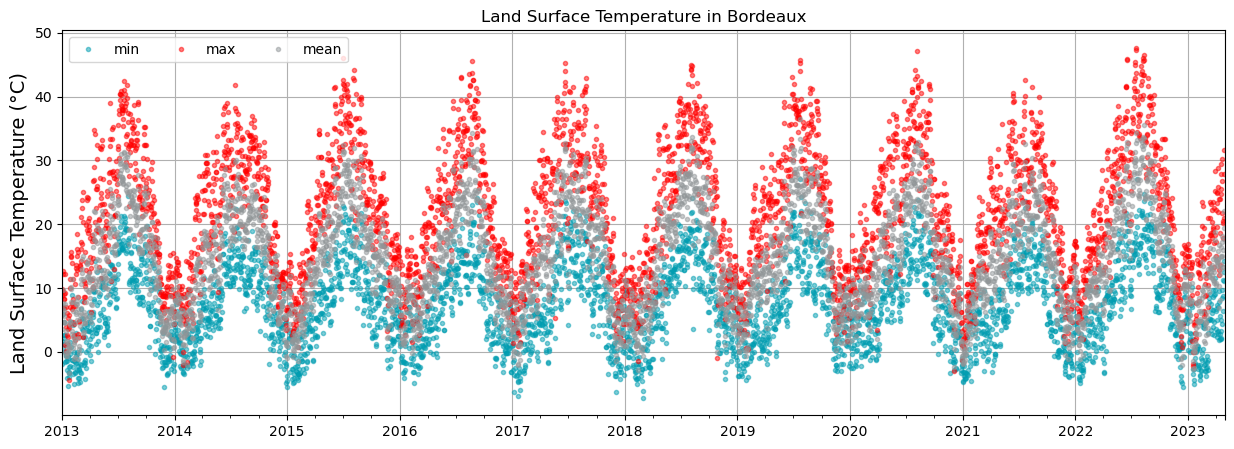

In [10]:
df["daily min"].plot(figsize=(15, 5), style = '.', c="#009db1", alpha=0.5, grid=True)
df["daily max"].plot(figsize=(15, 5), style = '.', c="r", alpha=0.5, grid=True)
df["daily mean"].plot(figsize=(15, 5), style = '.', c="#919698", alpha=0.5, grid=True)

plt.title("Land Surface Temperature in Bordeaux")
plt.legend(["min", "max", "mean", "climatology"], ncol=4, loc="upper left")
plt.ylabel('Land Surface Temperature (°C)', fontsize=14)
plt.show()

### Calculate positive anomaly

Research from Lozowski et al. (1989) revealed that the use of cumulative positive temperature anomalies highlights inter-annual climate fluctuations, and temporal dynamics in the data that do not readily appear in the raw data or in the more traditional statistical analysis. In our case, it can reveal the timing and accumulation of heat throughout the year by using the positive anomalies. It enables comparison across multiple years, allowing for an understanding of the accumulation and timing of temperature deviations. The colormap enhances the visualization, helping to identify long-term trends in changing deviations or increasing anomalies.

In [11]:
# Add the cumulative positive anomaly
backward_average_window_size = 10

# Calculate the backward average
df["rolling mean"] = df["daily mean"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1
).mean()[backward_average_window_size - 1:]

# Calculate the climatology
df["doy"] = df.index.dayofyear
df["climatology"] = df.groupby("doy")["rolling mean"].transform("mean")

# Calculate the anomaly
df["anomaly"] = df["rolling mean"] - df["climatology"]

# Calculate the yearly positive anomaly
df["year"] = df.index.year
df["positive_cumsum"] = df.groupby("year")["anomaly"].transform(lambda x: x.clip(lower=0).cumsum())

### Plot the cumulative positive anomaly

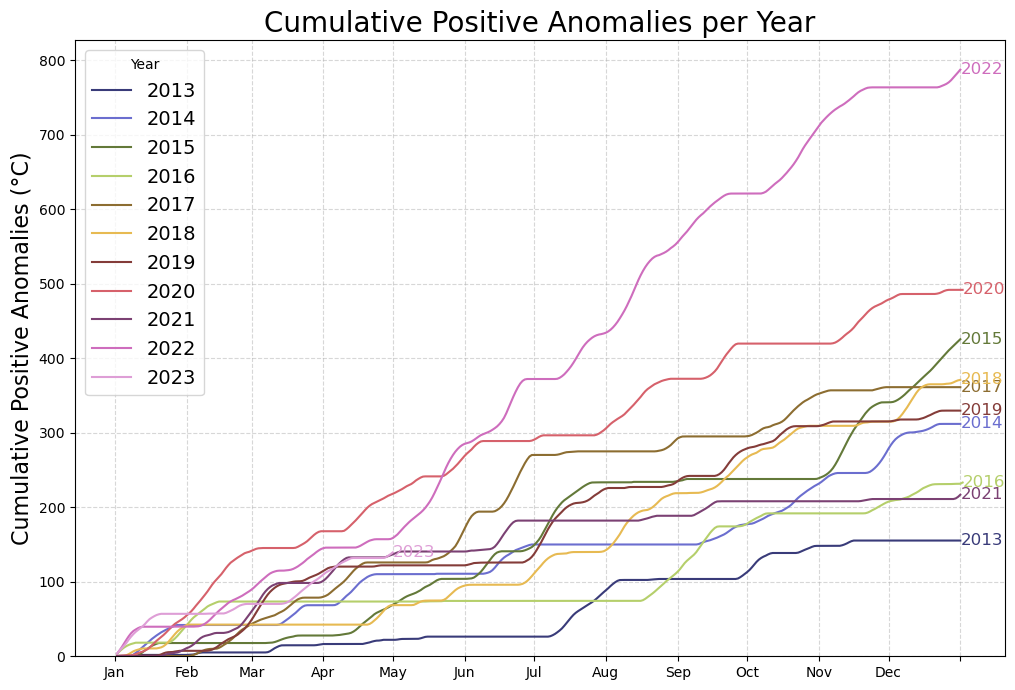

In [12]:
years = df["year"].unique()
colors = cm.tab20b(np.linspace(0, 1, len(years)))

# plot each year with different colors
plt.figure(figsize=(12, 8))
for year, color in zip(years, colors):
    df_subset = df[df["year"] == year].set_index("doy")["positive_cumsum"]
    ax = df_subset.plot(color=color, label=year)
    ax.text(df_subset.index[-1], df_subset.iloc[-1], str(year), color=color, fontsize=12, va='center', ha='left')

# format the figure
ax.set_ylim(bottom=0)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.set_xticks(ax.get_xticks())  # Ensure ticks are set before setting tick labels
tick_labels = [item.get_text() for item in ax.get_xticklabels()]
if tick_labels[-1] == 'Jan':
    tick_labels[-1] = ''
ax.set_xticklabels(tick_labels)

plt.legend(title='Year', loc='upper left', fontsize=14)
plt.title('Cumulative Positive Anomalies per Year', fontsize=20)
plt.ylabel('Cumulative Positive Anomalies (°C)', fontsize=16)
plt.xlabel('')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The cumulative sum highlights 2022 as the hottest year by far. This is supported by literature, which notes that May, June, July, and August 2022 were the warmest months in at least the last 15 years (Académie du Vin Library, 2023). Other notable hot year is 2020. In general, most heat accumulation occurs between May and September.

## 1.2 Estimate the Heat index based on the Excess Heat Factor

### 1.2.1 Detect the Heatwaves using the Excess Heat Factor
The Excess Heat Factor (EHF) is a method developed by Nairn & Fawcett in 2014, which identifies heatwaves by examining both maximum and minimum temperatures, as well as short- and long-term anomalies. The EHF is caluclated by multiplying the deviation of the three day average from the climatology with the deviation of the recent temperature from the preceding thirty days. This multiplication of two temperature differences results in a unit of °C². The squared unit amplifies the result, meaning that when both anomalies are high, the EHF value increases substantially.For further information, refer to the publication via [Nairn & Fawcett in 2014](https://doi.org/10.3390/ijerph120100227 ).

In [13]:
# Step 1: Calculate the Excess Heat Index : (T(i) + T(i-1) + T(i-2)) / 3 - T95
T95 = df['daily mean'].quantile(0.95)
df['EHI'] = df['daily mean'].rolling(window=3, min_periods=1).mean() - T95

# Step 2: Calculate the EHIaccl: EHIaccl = (T(i) + T(i-1) + T(i-2)) / 3 - (T(i-3) + ... + T(i-33)) / 30
df['3_day_mean'] = df['daily mean'].rolling(window=3, min_periods=1).mean()
df['30_day_mean'] = df['daily mean'].rolling(window=30, min_periods=1).apply(lambda x: x[:-3].mean(), raw=False)
df['EHIaccl'] = df['3_day_mean'] - df['30_day_mean']

# Step 3: Calculate the Excess Heat Factor (EHF): EHF = EHIsig * max(1, EHIaccl)
df['EHF'] = df['EHI'] * df['EHIaccl'].apply(lambda x: max(1, x))

# Step 4: Identify heatwaves: defined as a period of at least 3 consecutive days with EHF > 0
df['heatwave'] = False
for i in range(2, len(df)):
    if df['EHF'].iloc[i] > 0 and df['EHF'].iloc[i-1] > 0 and df['EHF'].iloc[i-2] > 0:
        df.loc[df.index[i], 'heatwave'] = True
        df.loc[df.index[i-1], 'heatwave'] = True
        df.loc[df.index[i-2], 'heatwave'] = True

df.head()

,daily min,daily max,gap_filled,daily mean,rolling mean,doy,climatology,anomaly,year,positive_cumsum,EHI,3_day_mean,30_day_mean,EHIaccl,EHF,heatwave
2013-01-01,1.689944,9.885899,False,5.787921,NaN,1,6.610669,NaN,2013,NaN,-22.109171,5.787921,NaN,NaN,-22.109171,False
2013-01-02,-1.872304,8.964494,True,3.546095,NaN,2,6.334377,NaN,2013,NaN,-23.230084,4.667008,NaN,NaN,-23.230084,False
2013-01-03,0.584775,12.709607,False,6.647191,NaN,3,6.028072,NaN,2013,NaN,-22.570023,5.327069,NaN,NaN,-22.570023,False
2013-01-04,7.024494,12.255731,True,9.640113,NaN,4,5.816547,NaN,2013,NaN,-21.285960,6.611133,5.787921,0.823212,-21.285960,False
2013-01-05,5.863483,9.577303,False,7.720393,NaN,5,5.564633,NaN,2013,NaN,-19.894527,8.002566,4.667008,3.335557,-66.359337,False


### 1.2.2 Find the most severe heatwaves and extract their characteristics
We will select the 4 heatwaves based on EHF (Excess Heat Factor)

In [14]:
number_of_heatwaves_to_display = 4

# Create a column to identify groups of consecutive heatwave periods
df['heatwave_group'] = (df['heatwave'] != df['heatwave'].shift()).cumsum()

# Initialize the heatwave list
heatwave_list = []

# Iterate over each group of consecutive heatwave periods
for group, heatwave_data in df[df['heatwave']].groupby('heatwave_group'):
    start_index = heatwave_data.index[0]
    end_index = heatwave_data.index[-1]

    # Calculate heatwave details
    length = len(heatwave_data)
    ehf_sum = heatwave_data['EHF'].sum()
    hottest_day_temp = heatwave_data['daily mean'].max()
    hottest_day = heatwave_data['daily mean'].idxmax()

    # Append to heatwave list
    heatwave_list.append({
        'start_date': start_index.strftime('%Y-%m-%d'),
        'end_date': end_index.strftime('%Y-%m-%d'),
        'length': length,
        'EHF_sum': ehf_sum,
        'hottest_day': hottest_day.strftime('%Y-%m-%d'),
        'hottest_day_temp': hottest_day_temp,
    })
# Convert heatwave list to a DataFrame for easy viewing
heatwave_df = pd.DataFrame(heatwave_list)

# Keep only the hightest EHF sum heatwaves
heatwave_df = heatwave_df.nlargest(number_of_heatwaves_to_display, 'EHF_sum')
heatwave_df.reset_index(drop=True, inplace=True)
heatwave_df

,start_date,end_date,length,EHF_sum,hottest_day,hottest_day_temp
0,2022-07-11,2022-07-21,11,206.592483,2022-07-18,34.249017
1,2022-08-01,2022-08-14,14,159.252066,2022-08-12,35.563567
2,2018-08-02,2018-08-08,7,147.867768,2018-08-05,33.682107
3,2022-06-14,2022-06-20,7,132.547305,2022-06-18,32.920927


The most severe heatwave occurred in 2022 from July 11 to 21, with an EHF sum of 206°C$^2$, and the hottest day recorded on July 18, when LSTs reached 34.25°C. This heatwave coincided with one of the three major heatwave events that affected France nationally, contributing to a record-breaking summer marked by prolonged periods of extreme heat.


# 2. Spatial analysis: Urban Heat Islands mapping

Leveraging Planet's cloud-free high resolution LST data, we can quantify the cumulative positive anomaly for each city pixel. This cumulative anomaly identifies regions within the city that experience the greatest heat intensity over time, offering a clear view of where the UHI effect is strongest.
This process involves several steps:

1.   Data Collection: Collect 20 years historical 1 km temperature data to determine average temperatures (climatology) for the region.
2. Anomaly Calculation: Calculate 100 m daily temperature anomalies by comparing observed temperatures with its climatology.
3. Cumulative Analysis: Add up positive anomalies over the course of the identified heatwave to highlight areas with sustained high temperatures.



In [15]:
# Sensing time of the satellite overpass (13:30 or 01:30)
sensing_time="1330"

# Update the climatology to the correct sensing time
if sensing_time == "1330":
    df["climatology"] = df.groupby("doy")["daily max"].transform("mean")
elif sensing_time == "0130":
    df["climatology"] = df.groupby("doy")["daily min"].transform("mean")

In the following cell, we will plot the cumulative positive anomaly above the "normal" temperature (climatology) for each pixel.<br>
Each of the heatwave event previously extracted will be displayed.

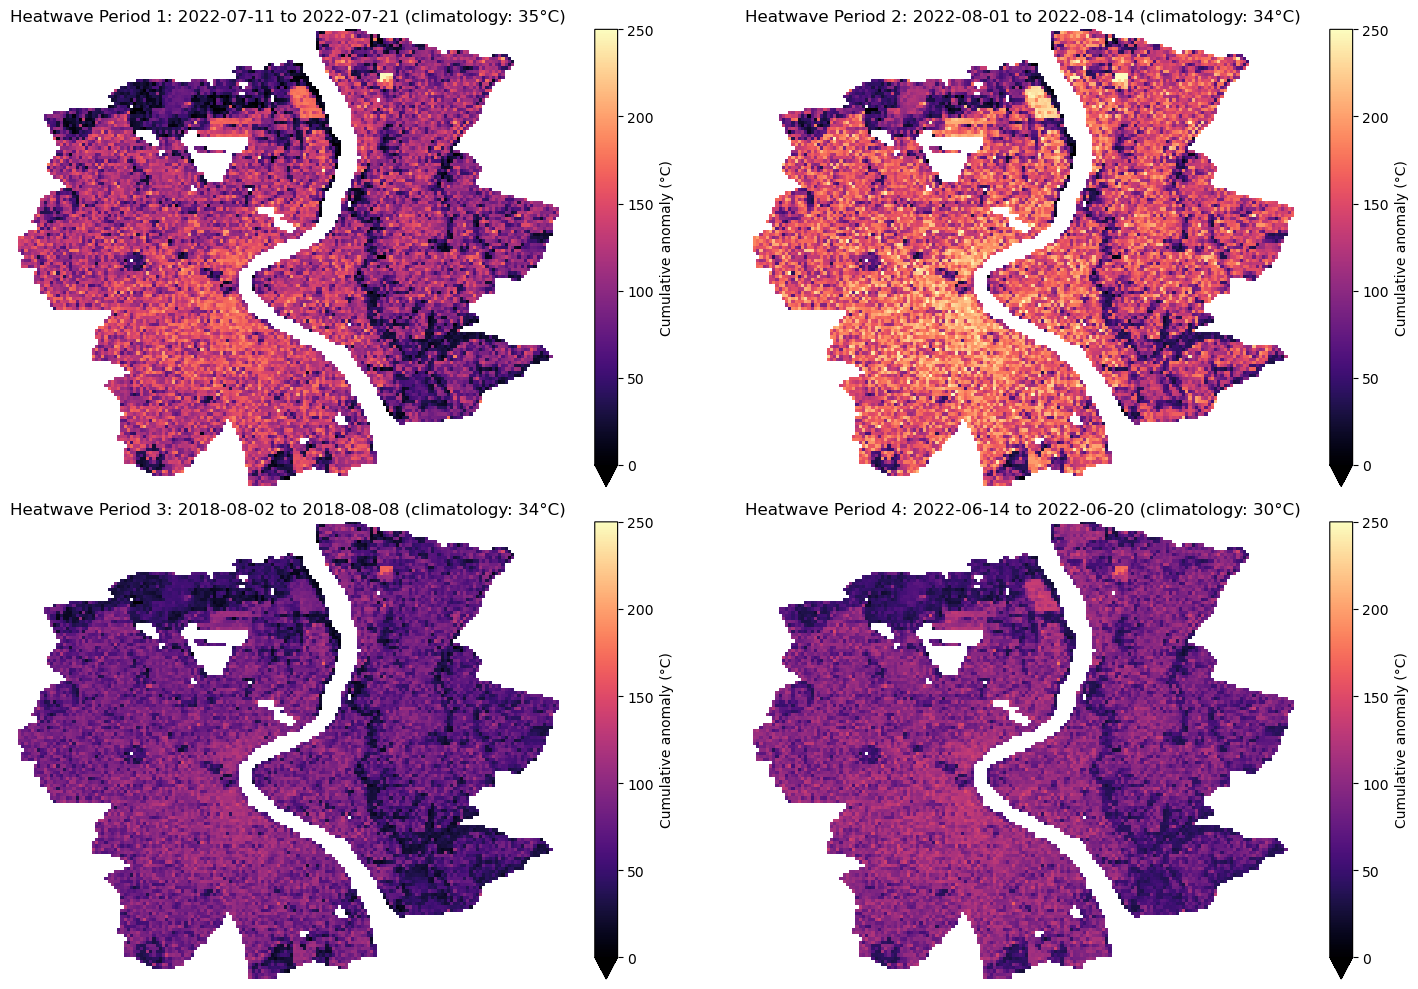

In [18]:
# Assuming heatwave_periods and LST_data are already defined
# Calculate the number of periods and determine the layout for subplots
num_periods = len(heatwave_df)
num_cols = 2
num_rows = (num_periods + 1) // num_cols

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Set the colormap and its properties
cmap = plt.get_cmap('magma')
cmap.set_under('black')
max_cumulative_temp = 250

# Iterate over each heatwave period
for i, heatwave_period in heatwave_df.iterrows():

    # Calculate the base temperature for LST normalization (in Celsius)
    base_temperature = df.loc[heatwave_period["start_date"]:heatwave_period["end_date"]]["climatology"].mean()

    # Define the evalscript for Sentinel Hub request
    evalscript_baseLST = f"""
    //VERSION=3
    sensing_time={sensing_time}
    function setup() {{
        return {{
            input: [{{bands: ["LST", "dataMask"]}}],
            output: [
                {{ id: "LST", bands: 1, sampleType: "FLOAT32" }},
            ],
            mosaicking: "TILE"
        }};
    }}

    // Filter out scenes where the sensing time matches specified sensing time
    function preProcessScenes (collections) {{
        collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {{
            return tile.dataPath.includes("T"+sensing_time);
        }})
        collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
        return collections
    }}


    function evaluatePixel(samples) {{
        let totalLST = 0;
        let count = 0;
        samples.forEach(sample => {{
            if (sample.dataMask == 1) {{
                totalLST += (sample.LST / 100) - 273.15 - {base_temperature};
                count++;
            }}
        }});

        return [totalLST === 0 ? NaN : totalLST];
    }}

    """
    request_LST = SentinelHubRequest(
        evalscript=evalscript_baseLST, # the evalscript defined above
        input_data=[
            SentinelHubRequest.input_data(
                DataCollection.define_byoc(collection_100m),
                time_interval=(heatwave_period["start_date"],heatwave_period["end_date"]),
            ),
        ],
        responses=[SentinelHubRequest.output_response("LST", MimeType.TIFF)],
        geometry=bordeaux_aoi,
        resolution=(0.001, 0.001),
        data_folder=".",
        config=config,
    )
    LST_data = request_LST.get_data()[0]

    if num_rows == 1:
        ax = axes[i]
    else:
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

    # Assuming LST_data is a 2D numpy array
    im = ax.imshow(LST_data, cmap=cmap, interpolation='nearest', vmin=0, vmax=max_cumulative_temp)
    ax.set_title(f"Heatwave Period {i+1}: {heatwave_period['start_date']} to {heatwave_period['end_date']} (climatology: {int(base_temperature)}°C)")
    cbar = fig.colorbar(im, ax=ax, extend='min')
    cbar.set_label('Cumulative anomaly (°C)') 
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

The figure illustrates cumulative positive temperature anomalies over Bordeaux during the four heatwaves, revealing a consistent spatial pattern despite variations in duration and baseline temperatures. Notably, the most severe heatwave, as measured by the EHF, accumulated less heat than the second most severe one.